In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import get_data
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.eval.calibration import compute_y_hat_ranks, compute_CDF_residuals
from bcnf.utils import get_dir

In [3]:
# X, y = get_data(
#     T=1.0,
#     dt=1 / 30,
#     N=2_000,
#     break_on_impact=False
# )

dataset_name = "hyperparameter_optimization_trajectories"
param_names = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z','g','w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r']

with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
    data = pickle.load(f)

X = np.array(data['traj'])
y = np.column_stack([np.array(data[param]) for param in param_names])

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024_03_25)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_train.shape=}')
print(f'{y_val.shape=}')


X_train.shape=(1600, 90, 3)
X_val.shape=(400, 90, 3)
y_train.shape=(1600, 19)
y_val.shape=(400, 19)


In [4]:
X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 270])
y_train_tensor.shape=torch.Size([1600, 19])
X_val_tensor.shape=torch.Size([400, 270])
y_val_tensor.shape=torch.Size([400, 19])


In [5]:
condition_size = 1024

In [6]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [X_train_tensor.shape[1]] + [1024] * 4 + [condition_size],
    dropout=0.4,
).to(device)

In [7]:
cnf = CondRealNVP(
    size=y_train.shape[1],
    nested_sizes=[256] * 2,
    n_blocks=24,
    n_conditions=condition_size,
    act_norm=True,
    feature_network=feature_network).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=2e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=250, threshold_mode="abs", threshold=1e-1
)

In [8]:
print(f'Number of parameters: {sum(p.numel() for p in cnf.parameters()):.2e}')

Number of parameters: 1.25e+07


In [9]:
loss_history = {}

In [10]:
train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=50_000,
    val_loss_patience=500,
    val_loss_tolerance=1e-1,
    batch_size=256,
    loss_history=loss_history
);

Train: 7.2335 - Val: 20.8557 (avg: 19.2540, min: 17.1794) | lr: 2.00e-04 - Patience: 179/500:   1%|          | 263/50000 [00:45<2:24:18,  5.74it/s] 


KeyboardInterrupt: 

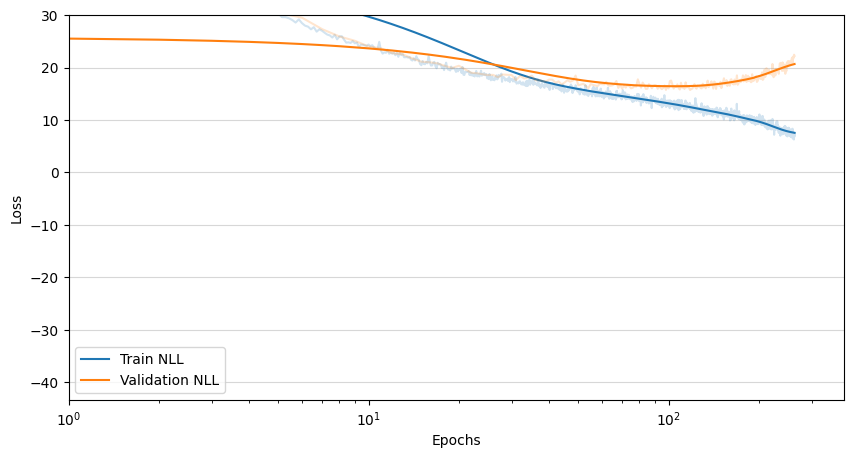

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=100)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=20)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(None, 30)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();

In [12]:
cnf.eval();

In [13]:
N_SAMPLES = 10000

In [14]:
y_hat = cnf.sample(n_samples=N_SAMPLES, y=X_val_tensor[0])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

(10000, 19)

In [15]:
y_prior = y_train_tensor.to('cpu').detach().numpy()

In [16]:
y_prior.shape

(1600, 19)

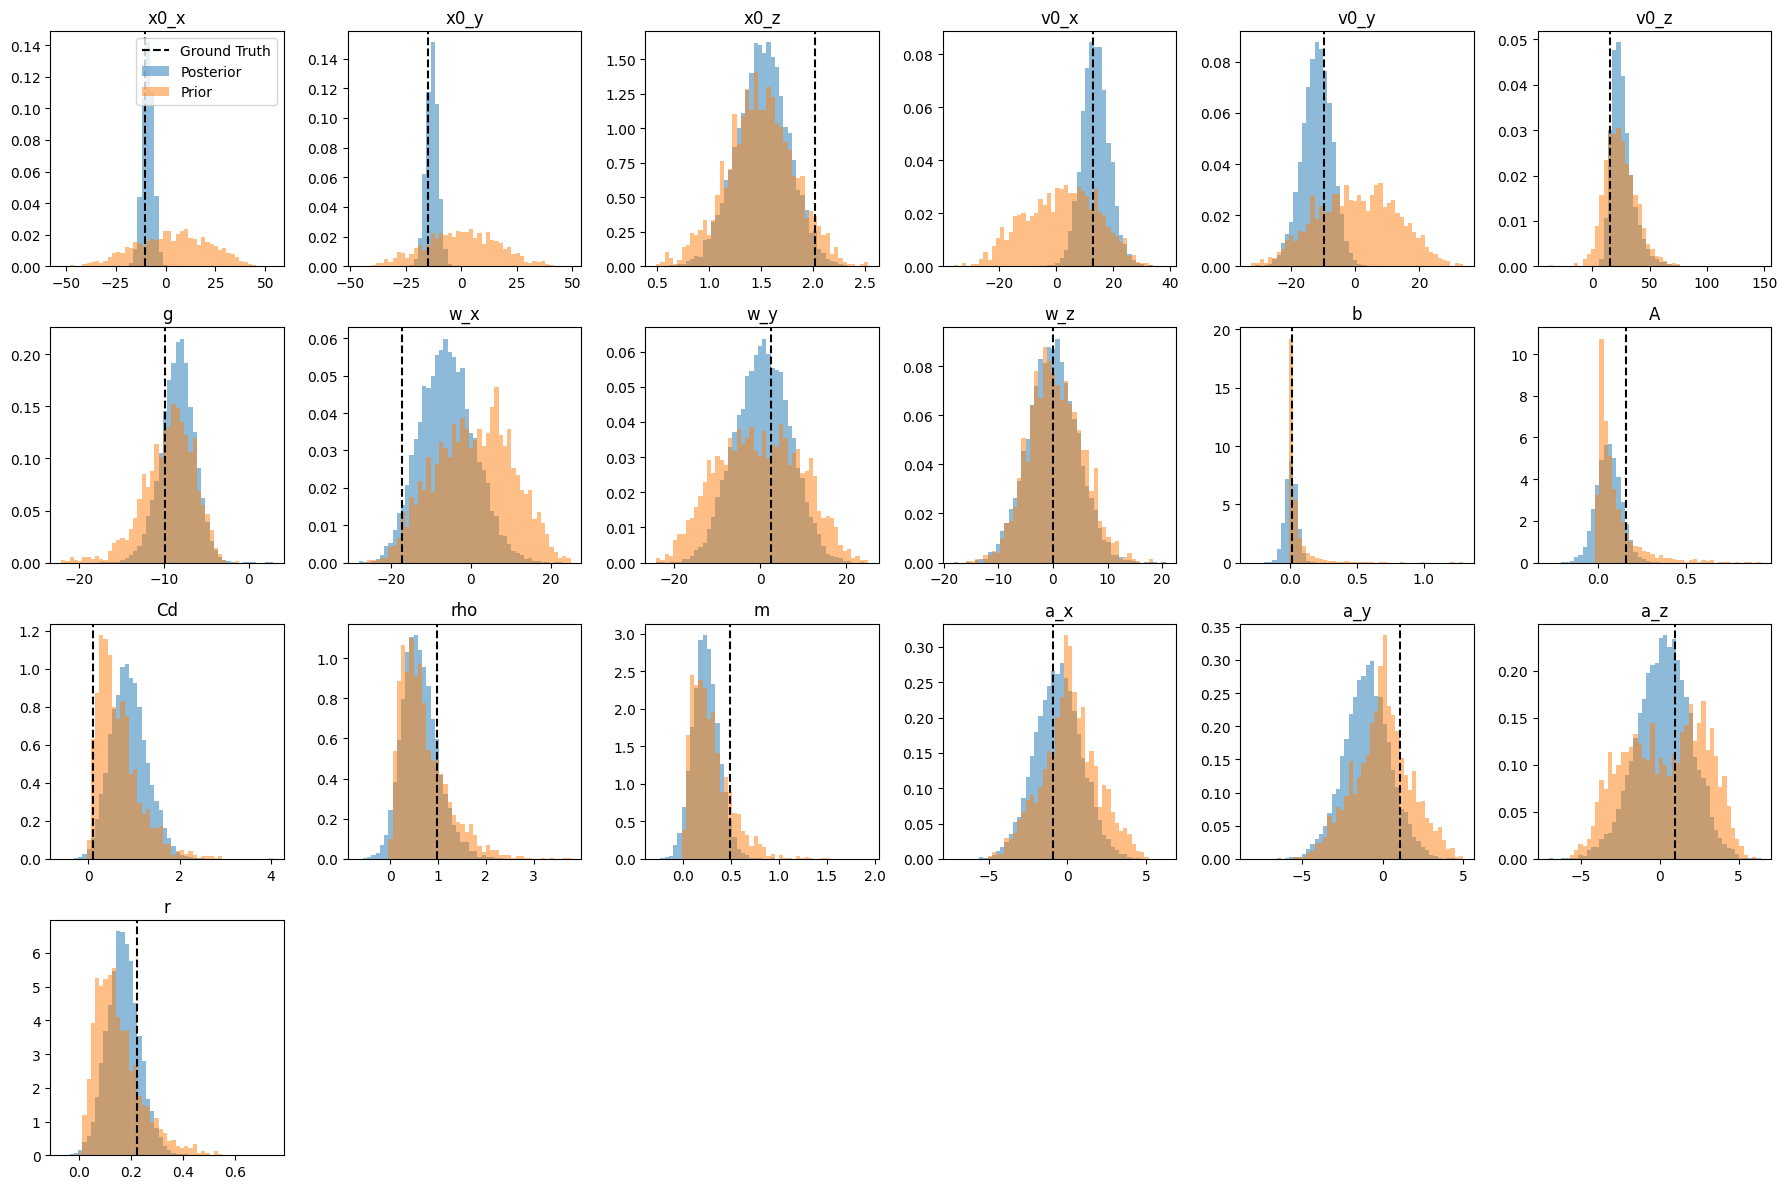

In [17]:
COLS = 6
ROWS = np.ceil(y_hat.shape[1] / COLS).astype(int)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

for i, name in zip(range(y_hat.shape[1]), param_names):
    vmin = np.min(np.concatenate([y_hat[:, i], y_prior[:, i]]))
    vmax = np.max(np.concatenate([y_hat[:, i], y_prior[:, i]]))
    ax.flatten()[i].axvline(y_val_tensor[0, i].cpu().detach().numpy(), color='k', linestyle='--', label='Ground Truth')
    ax.flatten()[i].hist(y_hat[:, i], alpha=0.5, color='C0', label='Posterior', bins=50, range=(vmin, vmax), density=True)
    ax.flatten()[i].set_title(name)

    # Show the prior
    ax.flatten()[i].hist(y_prior[:, i], alpha=0.5, color='C1', label='Prior', bins=50, range=(vmin, vmax), density=True)

for i in range(y_hat.shape[1], COLS * ROWS):
    ax.flatten()[i].axis('off')

ax[0, 0].legend()

fig.tight_layout();

# Calibration

In [18]:
from scipy.stats import binom

In [19]:
# N_samples = 10_000
N_samples = len(X_val_tensor)

In [20]:
# X_cal, y_cal = get_data(
#     T=1.0,
#     dt=0.1,
#     N=N_samples,
#     break_on_impact=False
# )

# X_cal_tensor = torch.tensor(X_cal.reshape(X_cal.shape[0], -1), dtype=torch.float32).to(device)
# y_cal_tensor = torch.tensor(y_cal, dtype=torch.float32).to(device)

In [21]:
cnf.eval();

In [22]:
M_samples = 10_000

In [23]:
y_cal_ranks = compute_y_hat_ranks(
    model=cnf,
    X=X_val_tensor,
    y=y_val_tensor,
    M_samples=M_samples,
    batch_size=100,
    device=device,
    output_device='cpu',
    verbose=False
)

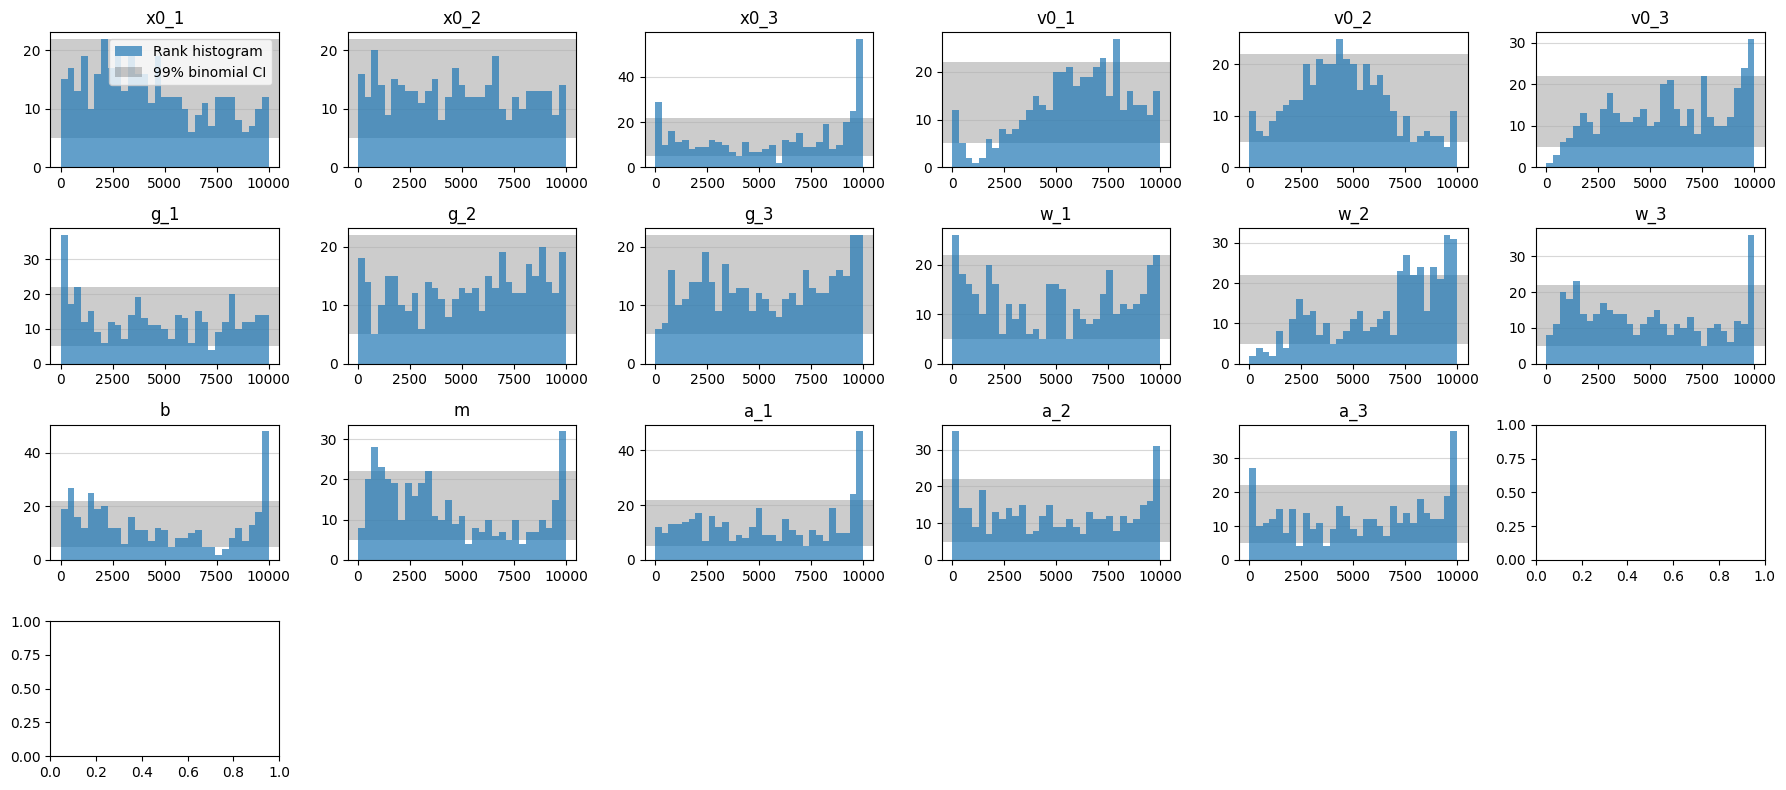

In [24]:
# Plot a histogram of the indices for each of the three parameters
COLS = 6
ROWS = np.ceil(y_cal_ranks.shape[1] / COLS).astype(int)

n_bins = 32
binomial_interval = 0.99

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

endpoints = binom.interval(binomial_interval, N_samples, 1 / n_bins)

n_bins_outliers = 0
n_bins_total = 0

for i, ax, name in zip(range(y_cal_ranks.shape[1]), axes.flatten(), ['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3']):
    hist = ax.hist(y_cal_ranks[:, i].detach().cpu().numpy(), bins=np.linspace(0, M_samples, n_bins), alpha=0.7, color='C0', zorder=2, label='Rank histogram')

    # Count how many bins are outside the interval
    n_bins_outliers += np.sum(hist[0] < endpoints[0]) + np.sum(hist[0] > endpoints[1])
    n_bins_total += n_bins

    ax.axhspan(endpoints[0], endpoints[1], facecolor="k", alpha=0.2, label=f'{binomial_interval * 100:.0f}% binomial CI')

    ax.set_title(name)

    ax.grid(axis='y', alpha=0.5, zorder=0)

axes[0, 0].legend()

for i in range(y_cal_ranks.shape[1], COLS * ROWS):
    axes.flatten()[i].axis('off')

fig.tight_layout()

In [25]:
print(f'Bins outside the interval: {n_bins_outliers} / {n_bins_total} ({n_bins_outliers / n_bins_total:.1%} vs {(1 - binomial_interval) * 100:.1f}% binomial interval)')

Bins outside the interval: 50 / 544 (9.2% vs 1.0% binomial interval)


In [26]:
t_linspace, scaled_residuals, confidence_interval = compute_CDF_residuals(
    y_hat_all_sorted_ranks=y_cal_ranks,
    M_samples=M_samples,
    sigma=3
)

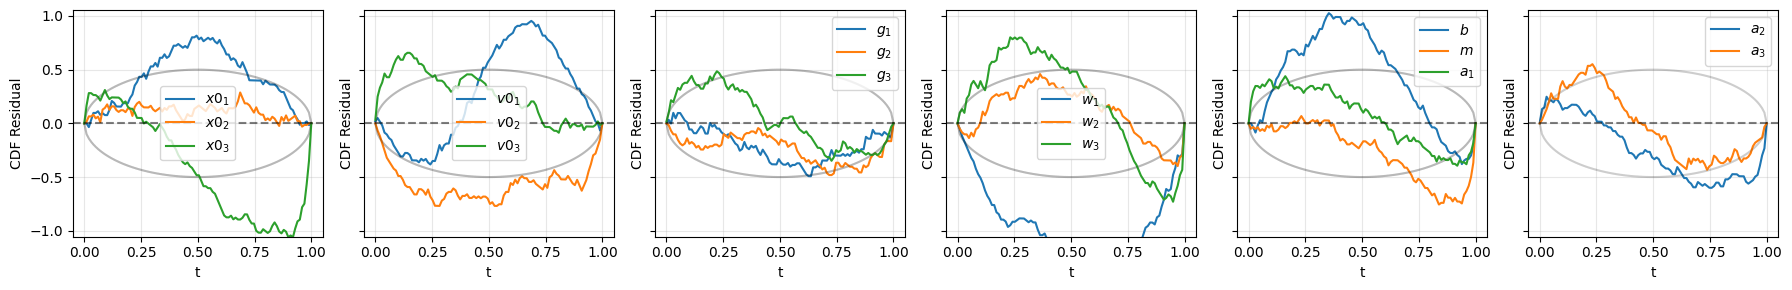

In [27]:
# Plot the residuals for X_0
n_curves_per_plot = 4
N_COLS = 6
N_ROWS = np.ceil(np.ceil(y_cal_ranks.shape[1] / n_curves_per_plot) / N_COLS).astype(int)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 3, N_ROWS * 3), sharey=True)

for indices, ax, param_names in zip(
    np.array_split(range(y_cal_ranks.shape[1]), N_ROWS * N_COLS),
    axes.flatten(),
    np.array_split(['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3'], N_ROWS * N_COLS)):
    
    for j, param_name in zip(indices, param_names):
        ax.plot(t_linspace, scaled_residuals[j, :], label=f"${param_name}$")

        ax.plot(t_linspace, confidence_interval, color='black', alpha=0.1)
        ax.plot(t_linspace, -confidence_interval, color='black', alpha=0.1)

    ax.set_xlabel("t")
    ax.set_ylabel("CDF Residual")

    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.legend()

    ylim = max(np.abs(scaled_residuals[indices, :].min()), np.abs(scaled_residuals[indices, :].max()))

    ax.set_ylim(-ylim * 1.5, ylim * 1.5)

    ax.grid(alpha=0.3)

fig.tight_layout()